In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 54.4 MB/s eta 0:00:00:00:0100:01


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
csv_path = "/kaggle/input/qm9-smiles-props/qm9_smiles_properties.csv" 
data = pd.read_csv(csv_path)
smiles = data["SMILES"]  
targets = data["G"]

In [ ]:
def featurize_smiles(smiles_list, radius=2, n_bits=1024):
    fingerprints = []
    for sm in smiles_list:
        mol = Chem.MolFromSmiles(sm)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fingerprints.append(np.array(fp))
        else:
            fingerprints.append(np.zeros(n_bits))
    return np.array(fingerprints)

features = featurize_smiles(smiles)

In [5]:
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [6]:
def preprocess_data(features, targets, train_size):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=1 - train_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=150, patience=5):
    train_losses, val_losses = [], []
    consecutive_increase_counter = 0
    prev_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss > prev_val_loss:
            consecutive_increase_counter += 1
        else:
            consecutive_increase_counter = 0

        prev_val_loss = val_loss

        if consecutive_increase_counter >= patience:
            print(f"Early stopping triggered after {patience} consecutive increases in validation loss!")
            break

    return train_losses, val_losses

In [9]:
def evaluate_model(model, test_loader, device):
    model.eval()
    actual_values = []
    predicted_values = []

    start_time = time.time()

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            actual_values.extend(y_batch.cpu().numpy())
            predicted_values.extend(outputs.cpu().numpy())

    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    end_time = time.time()

    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    inference_time = (end_time - start_time) / len(test_loader)

    print(f"Inference Time per 1000 samples: {inference_time*1000:.4f} seconds")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    return actual_values, predicted_values

In [14]:
def plot_metrics(train_losses, val_losses):
    plt.plot(train_losses[1:], label='Train Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_predictions(actual_values, predicted_values):
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
    plt.plot(
        [min(actual_values), max(actual_values)],
        [min(actual_values), max(actual_values)],
        color="red",
        linestyle="--",
        label="Ideal Fit"
    )
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
def main(train_size, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"\nTraining with {int(train_size * 100)}% of the data:")
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(features, targets, train_size)
    train_loader, val_loader, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

    input_dim = X_train.shape[1]
    model = ANN(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)

    plot_metrics(train_losses, val_losses)

    actual_values, predicted_values = evaluate_model(model, test_loader, device)

    plot_predictions(actual_values, predicted_values)


Training with 75% of the data:
Epoch [1/100], Train Loss: 2617.7540, Val Loss: 573.2647
Epoch [2/100], Train Loss: 529.9960, Val Loss: 544.6748
Epoch [3/100], Train Loss: 467.7641, Val Loss: 482.3366
Epoch [4/100], Train Loss: 422.9229, Val Loss: 431.3633
Epoch [5/100], Train Loss: 378.8364, Val Loss: 445.0162
Epoch [6/100], Train Loss: 331.6116, Val Loss: 445.1011
Epoch [7/100], Train Loss: 284.0817, Val Loss: 371.9343
Epoch [8/100], Train Loss: 237.4604, Val Loss: 366.6659
Epoch [9/100], Train Loss: 205.5622, Val Loss: 374.0235
Epoch [10/100], Train Loss: 175.5165, Val Loss: 381.3325
Epoch [11/100], Train Loss: 148.7978, Val Loss: 357.8179
Epoch [12/100], Train Loss: 124.2711, Val Loss: 344.4492
Epoch [13/100], Train Loss: 108.6675, Val Loss: 339.0292
Epoch [14/100], Train Loss: 95.8351, Val Loss: 335.5356
Epoch [15/100], Train Loss: 84.4478, Val Loss: 327.1367
Epoch [16/100], Train Loss: 75.4301, Val Loss: 327.5101
Epoch [17/100], Train Loss: 68.9803, Val Loss: 323.7750
Epoch [18/1

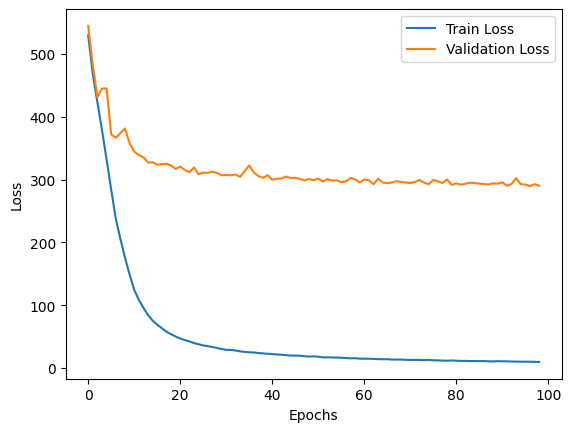

Inference Time per 1000 samples: 0.7852 seconds
Mean Squared Error (MSE): 287.5763
Mean Absolute Error (MAE): 11.9760
R-Squared (R²): 0.8199


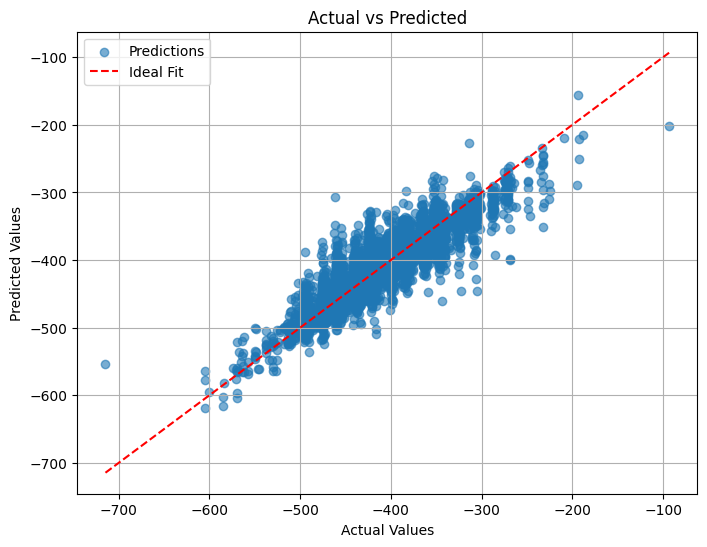

In [19]:
main(0.75, 100)


Training with 60% of the data:
Epoch [1/150], Train Loss: 3076.0961, Val Loss: 653.3096
Epoch [2/150], Train Loss: 552.5745, Val Loss: 603.6524
Epoch [3/150], Train Loss: 478.9679, Val Loss: 468.4534
Epoch [4/150], Train Loss: 428.4298, Val Loss: 484.2393
Epoch [5/150], Train Loss: 400.8494, Val Loss: 420.1818
Epoch [6/150], Train Loss: 369.1760, Val Loss: 425.0201
Epoch [7/150], Train Loss: 322.6084, Val Loss: 394.5609
Epoch [8/150], Train Loss: 281.5398, Val Loss: 423.2382
Epoch [9/150], Train Loss: 237.5411, Val Loss: 418.6845
Epoch [10/150], Train Loss: 208.2885, Val Loss: 372.9702
Epoch [11/150], Train Loss: 176.3901, Val Loss: 389.9777
Epoch [12/150], Train Loss: 149.8471, Val Loss: 380.6179
Epoch [13/150], Train Loss: 129.0184, Val Loss: 371.3544
Epoch [14/150], Train Loss: 110.1365, Val Loss: 363.6070
Epoch [15/150], Train Loss: 95.7626, Val Loss: 378.3473
Epoch [16/150], Train Loss: 85.0537, Val Loss: 386.3546
Epoch [17/150], Train Loss: 75.1914, Val Loss: 384.2373
Epoch [18/

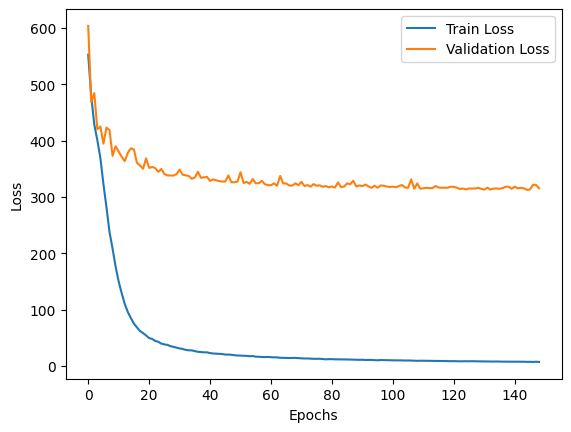

Inference Time per 1000 samples: 0.7643 seconds
Mean Squared Error (MSE): 307.7243
Mean Absolute Error (MAE): 12.5052
R-Squared (R²): 0.8052


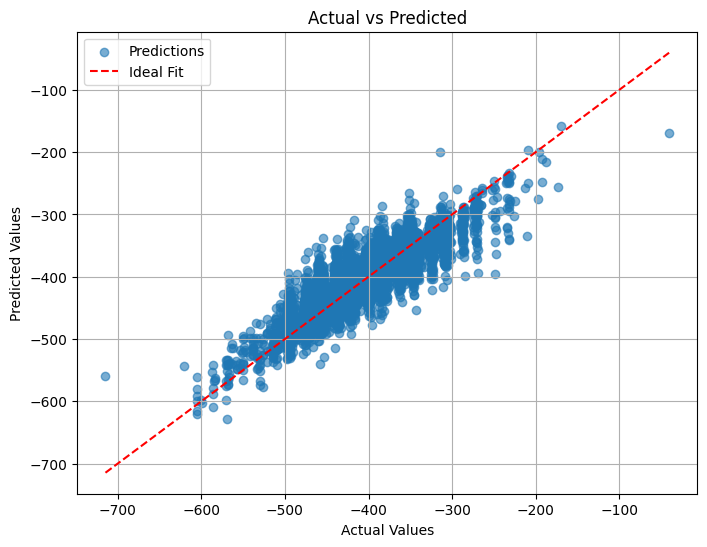

In [20]:
main(0.6, 150)


Training with 45% of the data:
Epoch [1/150], Train Loss: 3860.7034, Val Loss: 683.3859
Epoch [2/150], Train Loss: 584.1026, Val Loss: 524.4305
Epoch [3/150], Train Loss: 491.9641, Val Loss: 488.5304
Epoch [4/150], Train Loss: 444.7927, Val Loss: 456.0346
Epoch [5/150], Train Loss: 416.2107, Val Loss: 504.4537
Epoch [6/150], Train Loss: 391.3960, Val Loss: 441.0194
Epoch [7/150], Train Loss: 363.3568, Val Loss: 458.3456
Epoch [8/150], Train Loss: 332.7129, Val Loss: 515.4070
Epoch [9/150], Train Loss: 298.8785, Val Loss: 466.9581
Epoch [10/150], Train Loss: 261.0307, Val Loss: 456.4306
Epoch [11/150], Train Loss: 222.6902, Val Loss: 427.7530
Epoch [12/150], Train Loss: 190.7690, Val Loss: 495.0678
Epoch [13/150], Train Loss: 159.4752, Val Loss: 427.6062
Epoch [14/150], Train Loss: 135.7112, Val Loss: 424.1629
Epoch [15/150], Train Loss: 121.4606, Val Loss: 438.2411
Epoch [16/150], Train Loss: 102.5027, Val Loss: 429.8123
Epoch [17/150], Train Loss: 89.8926, Val Loss: 440.8527
Epoch [1

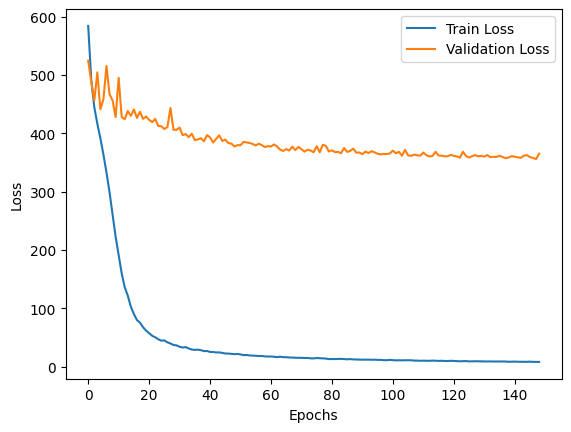

Inference Time per 1000 samples: 0.8019 seconds
Mean Squared Error (MSE): 360.1455
Mean Absolute Error (MAE): 13.6055
R-Squared (R²): 0.7772


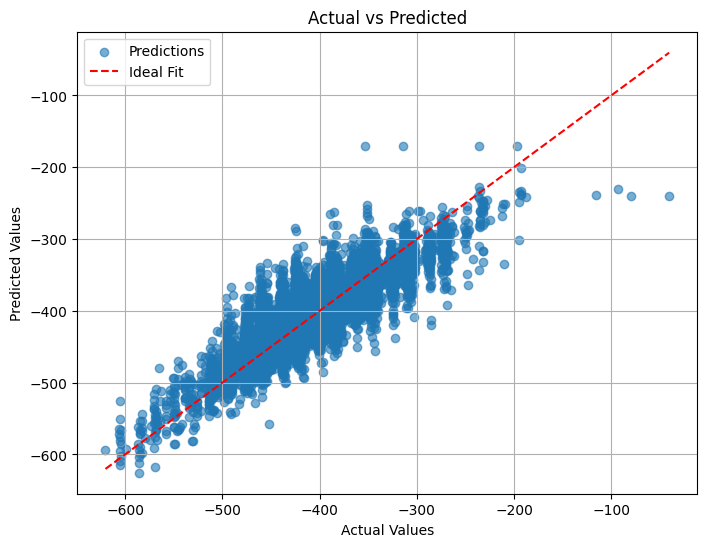

In [22]:
main(0.45, 150)


Training with 30% of the data:
Epoch [1/150], Train Loss: 5678.1107, Val Loss: 930.8223
Epoch [2/150], Train Loss: 765.1735, Val Loss: 700.7838
Epoch [3/150], Train Loss: 560.0092, Val Loss: 561.1187
Epoch [4/150], Train Loss: 490.1911, Val Loss: 508.8895
Epoch [5/150], Train Loss: 445.6918, Val Loss: 528.3023
Epoch [6/150], Train Loss: 415.6768, Val Loss: 486.4381
Epoch [7/150], Train Loss: 386.3773, Val Loss: 507.9706
Epoch [8/150], Train Loss: 365.3870, Val Loss: 494.2555
Epoch [9/150], Train Loss: 347.6260, Val Loss: 497.1399
Epoch [10/150], Train Loss: 320.7339, Val Loss: 516.3441
Epoch [11/150], Train Loss: 300.2643, Val Loss: 474.8596
Epoch [12/150], Train Loss: 264.9990, Val Loss: 506.1758
Epoch [13/150], Train Loss: 234.2133, Val Loss: 487.5350
Epoch [14/150], Train Loss: 205.0340, Val Loss: 495.4831
Epoch [15/150], Train Loss: 181.6729, Val Loss: 554.5931
Epoch [16/150], Train Loss: 154.3542, Val Loss: 497.1590
Epoch [17/150], Train Loss: 133.0422, Val Loss: 495.9028
Epoch [

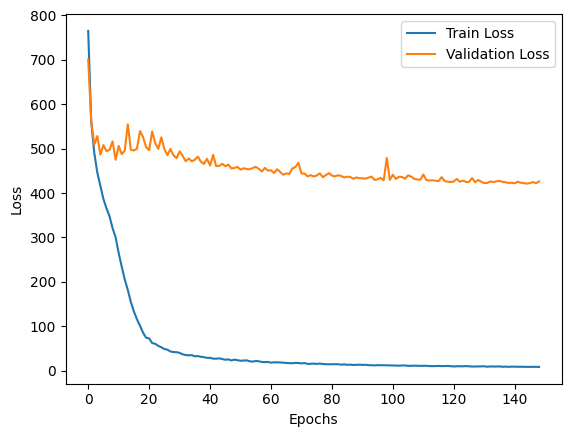

Inference Time per 1000 samples: 0.8102 seconds
Mean Squared Error (MSE): 434.4015
Mean Absolute Error (MAE): 15.3522
R-Squared (R²): 0.7304


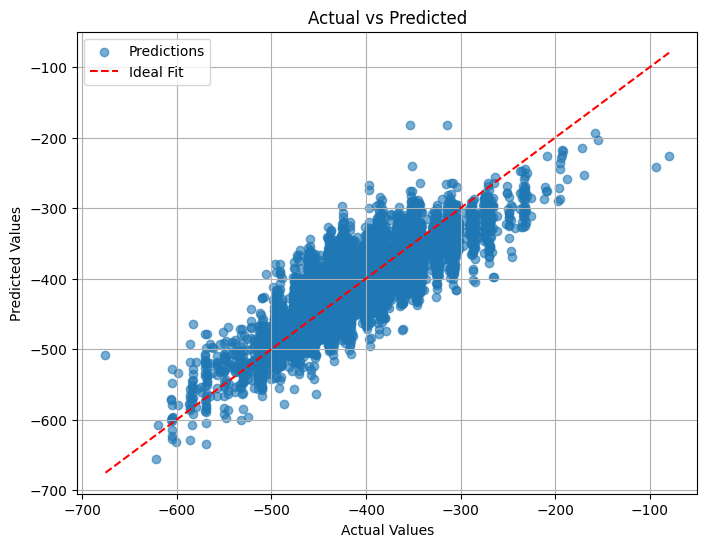

In [23]:
main(0.3, 150)


Training with 15% of the data:
Epoch [1/150], Train Loss: 9592.1635, Val Loss: 1219.7014
Epoch [2/150], Train Loss: 1017.6063, Val Loss: 881.1720
Epoch [3/150], Train Loss: 701.4826, Val Loss: 674.3644
Epoch [4/150], Train Loss: 555.2982, Val Loss: 596.5693
Epoch [5/150], Train Loss: 480.5502, Val Loss: 569.1585
Epoch [6/150], Train Loss: 427.7611, Val Loss: 546.3358
Epoch [7/150], Train Loss: 379.7032, Val Loss: 548.8539
Epoch [8/150], Train Loss: 342.0313, Val Loss: 539.4359
Epoch [9/150], Train Loss: 319.8224, Val Loss: 615.5088
Epoch [10/150], Train Loss: 292.7538, Val Loss: 563.3675
Epoch [11/150], Train Loss: 260.4762, Val Loss: 573.7013
Epoch [12/150], Train Loss: 234.1994, Val Loss: 618.9167
Epoch [13/150], Train Loss: 225.9523, Val Loss: 589.9719
Epoch [14/150], Train Loss: 201.2040, Val Loss: 577.9771
Epoch [15/150], Train Loss: 180.3785, Val Loss: 635.4734
Epoch [16/150], Train Loss: 162.1094, Val Loss: 592.5266
Epoch [17/150], Train Loss: 154.9278, Val Loss: 648.9645
Epoch

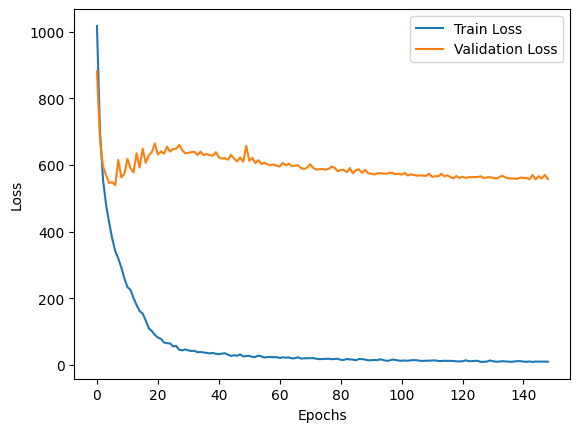

Inference Time per 1000 samples: 0.7839 seconds
Mean Squared Error (MSE): 571.5742
Mean Absolute Error (MAE): 17.8153
R-Squared (R²): 0.6454


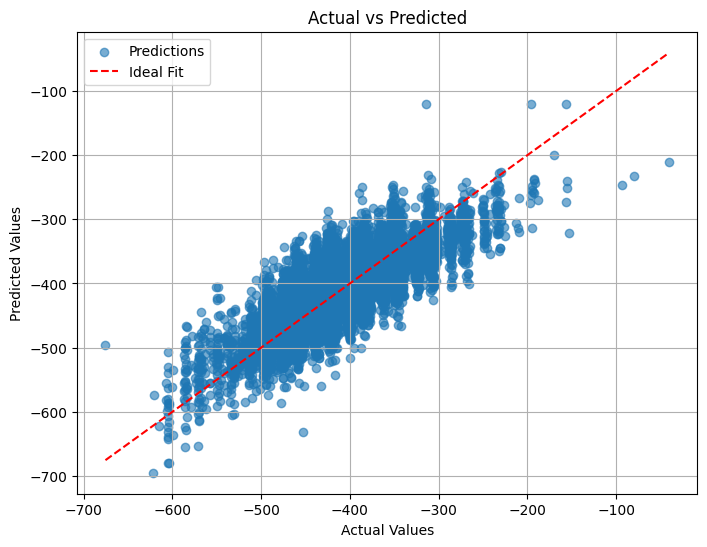

In [24]:
main(0.15, 150)